
# Example: crack branching

See Section 5.2 Crack Branching in Homalite in [1]

[1] Bobaru, F., & Zhang, G. (2015). Why do cracks branch? A peridynamic 
investigation of dynamic brittle fracture. International Journal of Fracture,
196, 59-98.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import google.colab
    IN_COLAB = True
    !pip install git+https://github.com/mark-hobbs/PyPD.git
    print("Package installed successfully")
    import pypd
except ImportError:
    IN_COLAB = False
    import pypd
    print("Not running in Colab")

Not running in Colab


In [2]:
def build_particle_coordinates(dx, n_div_x, n_div_y):
    particle_coordinates = np.zeros([n_div_x * n_div_y, 2])
    counter = 0

    for i_y in range(n_div_y):      # depth
        for i_x in range(n_div_x):  # length
            coord_x = dx * i_x
            coord_y = dx * i_y
            particle_coordinates[counter, 0] = coord_x
            particle_coordinates[counter, 1] = coord_y
            counter += 1

    return particle_coordinates

In [3]:
def build_boundary_conditions(particles, dx):
    bc_flag = np.zeros((len(particles), 2), dtype=np.intc)
    bc_unit_vector = np.zeros((len(particles), 2), dtype=np.intc)

    tol = 1e-6

    for i, particle in enumerate(particles):
        if particle[1] < (0.02 + tol):
            bc_flag[i, 1] = 1
            bc_unit_vector[i, 1] = -1
        if particle[1] > (0.18 - dx - tol):
            bc_flag[i, 1] = 1
            bc_unit_vector[i, 1] = 1

    return bc_flag, bc_unit_vector

In [4]:
def build_notch(x, bondlist, notch):
    n_nodes = np.shape(x)[0]
    n_bonds = np.shape(bondlist)[0]

    P1 = notch[0]
    P2 = notch[1]

    mask = []

    for k_bond in range(n_bonds):
        node_i = bondlist[k_bond, 0]
        node_j = bondlist[k_bond, 1]

        P3 = x[node_i]
        P4 = x[node_j]

        intersect = determine_intersection(P1, P2, P3, P4)

        if intersect == True:
            mask.append(k_bond)

    reduced_bondlist = np.delete(bondlist, mask, axis=0)
    n_family_members = rebuild_node_families(n_nodes, reduced_bondlist)

    return reduced_bondlist, n_family_members

In [5]:
def determine_intersection(P1, P2, P3, P4):
    """
    Determine if a bond intersects with a notch
        - Given two line segments, find if the
          given line segments intersect with
          each other.

    Parameters
    ----------
    P :
        P = (x, y)

    Returns
    ------
    Returns True if two lines intersect

    Notes
    -----
    * This solution is based on the following
      paper:

      Antonio, F. (1992). Faster line segment
      intersection. In Graphics Gems III
      (IBM Version) (pp. 199-202). Morgan
      Kaufmann.

    """

    A = P2 - P1
    B = P3 - P4
    C = P1 - P3

    denominator = (A[1] * B[0]) - (A[0] * B[1])

    alpha_numerator = (B[1] * C[0]) - (B[0] * C[1])
    beta_numerator = (A[0] * C[1]) - (A[1] * C[0])

    alpha = alpha_numerator / denominator
    beta = beta_numerator / denominator

    if (0 <= alpha <= 1) and (0 <= beta <= 1):
        intersect = True
    else:
        intersect = False

    return intersect

In [6]:
def rebuild_node_families(n_nodes, bondlist):
    n_bonds = np.shape(bondlist)[0]
    n_family_members = np.zeros(n_nodes)

    for k_bond in range(n_bonds):
        node_i = bondlist[k_bond, 0]
        node_j = bondlist[k_bond, 1]

        n_family_members[node_i] += 1
        n_family_members[node_j] += 1

    return n_family_members

In [7]:
dx = 1e-3
n_div_x = np.rint(0.4 / dx).astype(int)
n_div_y = np.rint(0.2 / dx).astype(int)
notch = [np.array([0 - dx, 0.1 - (dx / 2)]), 
         np.array([0.2, 0.1 - (dx / 2)])]

In [8]:
x = build_particle_coordinates(dx, n_div_x, n_div_y)
flag, unit_vector = build_boundary_conditions(x, dx)

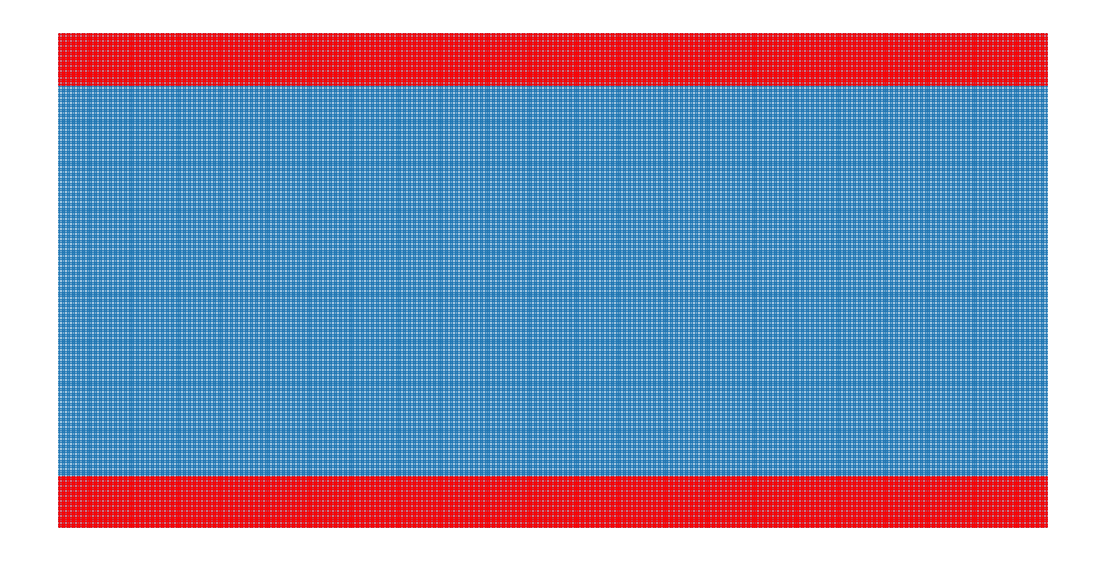

In [9]:
fig, ax = plt.subplots(figsize=(14, 7.5))
ax.scatter(x[:, 0], x[:, 1], marker='o', s=1)
ax.scatter(x[np.where(flag)[0], 0], x[np.where(flag)[0], 1], marker='o', s=1, c='red')
ax.axis('off')
ax.set_aspect('equal')

In [10]:
material = pypd.Material(
    name="homalite", E=4.55e9, Gf=38.46, density=1230, ft=2.5
)
integrator = pypd.EulerCromer()
bc = pypd.BoundaryConditions(flag, unit_vector, magnitude=1e-4)
particles = pypd.ParticleSet(x, dx, bc, material)
linear = pypd.Linear(material, particles, t=dx)
bonds = pypd.BondSet(particles, linear)
bonds.bondlist, particles.n_family_members = build_notch(
    particles.x, bonds.bondlist, notch
)
simulation = pypd.Simulation(dt=None, n_time_steps=5000, damping=0)
model = pypd.Model(
    particles,
    bonds,
    simulation,
    integrator,
    linear,
    animation=None
)

/var/folders/sd/1dk73p6d7vd2r7hct50p360r0000gn/T/ipykernel_71171/2718177617.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/var/folders/sd/1dk73p6d7vd2r7hct50p360r0000gn/T/ipykernel_71171/2718177617.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator


Simulation Progress: 100%|███████████████████████████████████████████████████████████| 5000/5000 [00:27<00:00, 184.45steps/s]


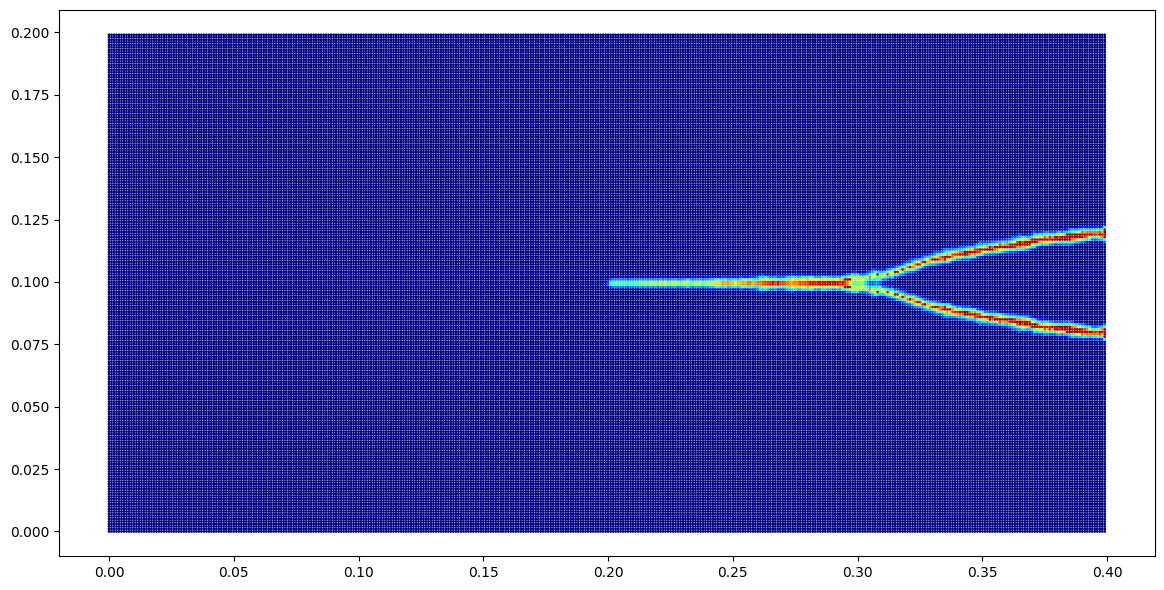

In [11]:
model.run_simulation()
model.save_final_state_fig(fig_title='crack-branching')